In [5]:
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [6]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
pipelines = {
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))]),
    'DT': Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier())]),
    'LR': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())]),
    'RF': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())])
}

param_grids = {
    'KNN': {
        'clf__n_neighbors': range(3, 11),
        'clf__weights': ['uniform', 'distance']
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['rbf', 'linear']
    },
    'DT': {
        'clf__max_depth': [None, 3, 5, 7],
        'clf__min_samples_split': [2, 5, 10]
    },
    'LR': {
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    'RF': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 5, 10]
    }
}

In [8]:
results = []
best_models = {}

for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Algorithm': name,
        'Test Accuracy': acc,
        'Best Params': grid.best_params_
    })

results_df = pd.DataFrame(results)
results_df

/opt/anaconda3/envs/test/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/opt/anaconda3/envs/test/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/opt/anaconda3/envs/test/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use anothe

,Algorithm,Test Accuracy,Best Params
0,KNN,0.933333,"{'clf__n_neighbors': 9, 'clf__weights': 'dista..."
1,SVM,0.911111,"{'clf__C': 0.1, 'clf__kernel': 'linear'}"
2,DT,0.977778,"{'clf__max_depth': None, 'clf__min_samples_spl..."
3,LR,0.911111,"{'clf__C': 1, 'clf__solver': 'lbfgs'}"
4,RF,0.888889,"{'clf__max_depth': None, 'clf__n_estimators': 50}"


In [9]:
best_model = best_models['DT']
joblib.dump(best_model, 'best_classifier.joblib')

['best_classifier.joblib']

In [10]:
loaded_model = joblib.load('best_classifier.joblib')
original_preds = best_model.predict(X_test[:5])
loaded_preds = loaded_model.predict(X_test[:5])

print("Original preds:", original_preds)
print("Loaded preds:  ", loaded_preds)
print("Match:", np.array_equal(original_preds, loaded_preds))

Original preds: [2 1 2 1 2]
Loaded preds:   [2 1 2 1 2]
Match: True


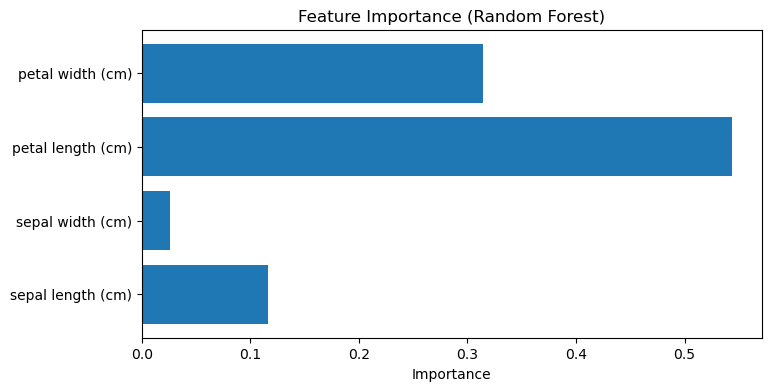

In [11]:
import matplotlib.pyplot as plt

rf_model = best_models['RF'].named_steps['clf']
importances = rf_model.feature_importances_
feature_names = load_iris().feature_names

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

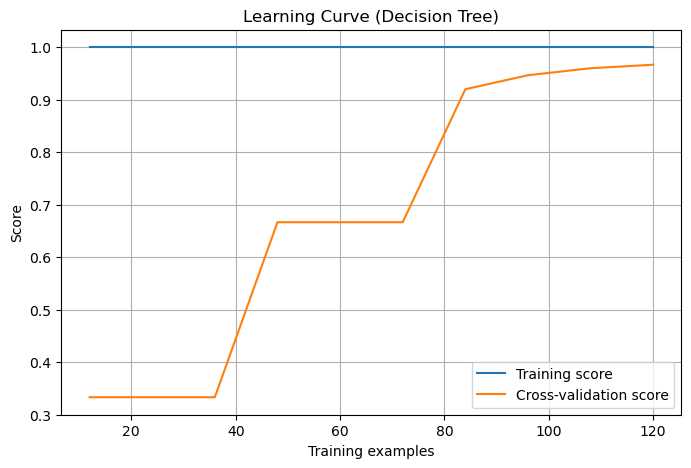

In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning Curve (Decision Tree)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()